### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 5: CNN

Dans ce laboratoire, nous allons implémenter avec l'aide de PyTorch divers réseaux à convolutions. La [documentation de PyTorch](https://pytorch.org/docs/stable/index.html) va donc vous être d'un grand secours. Entre autres, la documentation de [`torch`](https://pytorch.org/docs/stable/torch.html), [`torch.nn`](https://pytorch.org/docs/stable/nn.html) (que nous avons importé sous le nom de `nn`) ainsi que [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) (que nous avons importé sous le nom de `F`). En particulier, voici une liste de classes ou de fonctions dont vous êtes susceptible d'utiliser au cours de ce laboratoire.
- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
- [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
- [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList)

In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from deeplib.training import train, test
import torch.optim as optim
import torch
import numpy as np
from deeplib.datasets import load_cifar10, load_mnist
from deeplib.visualization import view_filters
import torch.nn.functional as F
import torch.nn as nn
from random import randrange

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified
Files already downloaded and verified


## Filtres de convolution

Lors de l'entraînement, le réseau apprend les bons paramètres à utiliser. Par contre, autrefois, il fallait utiliser des filtres faits à la main comme [les filtres de Gabor](https://en.wikipedia.org/wiki/Gabor_filter).

#### Exercice

- Le réseau suivant contient une seule couche à convolution. Créez manuellement quelques filtres que vous utiliserez pour faire de la classification sur CIFAR10. Par la suite, figez les poids de la couche de convolution et entraînez le réseau. Tentez d'obtenir les meilleurs résultats possibles.

In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.fc = nn.Linear(6 * 14 * 14, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

Modifier les paramètres des filtres. Essayez de faire des filtres permettant d'extraire des caractéristiques de bas niveau (ligne, coin, etc...). Vous pouvez consulter [ceci](http://lodev.org/cgtutor/filtering.html) pour avoir des idées.

In [55]:
filters = []
filters.append([[[0, 0, 0],
                 [0, 1, 0],
                 [0, 0, 0]]]) # Ce filtre retourne l'image original

"""
filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])
"""

# Arete verticales
filters.append([[[-1, 0, 1],
                 [-1, 0, 1],
                 [-1, 0, 1]]])

# Aretes horizontales
filters.append([[[-1, -1, -1],
                 [0, 0, 0],
                 [1, 1, 1]]])

# Motion blur (gaussien)
filters.append([[[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]])

# Arete toute directions
filters.append([[[-1, -1, -1],
                 [-1, 8, -1],
                 [-1, -1, -1]]])

# Emboss (shadow effect of image)
filters.append([[[-1, -1, 0],
                 [-1, 0, 1],
                 [0, 1, 1]]])


In [56]:
# On crée le réseau, remplace les paramètres par les filtres précédents et fige les poids.

net = Net()
# filters = np.asarray(filters, dtype=np.float32)
# net.conv1.weight.data = torch.from_numpy(filters)
net.conv1.weight.data = torch.FloatTensor(filters)
for param in net.conv1.parameters():
    param.requires_grad = False # Ceci fige chacune des couches
net = net.cuda()

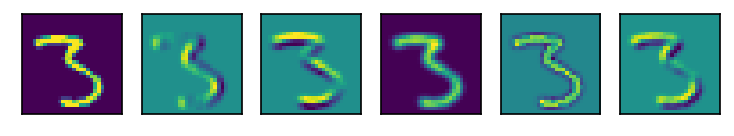

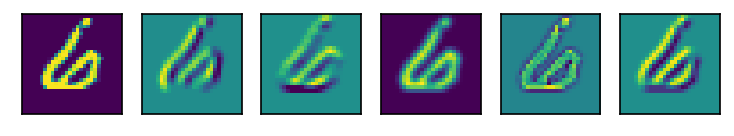

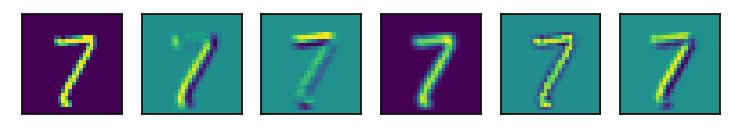

In [57]:
# Vous pouvez utiliser cette cellule pour visualiser l'effet de vos filtres sur des images du dataset.
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

In [58]:
lr = 0.001
n_epoch = 5
batch_size = 32

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.08s loss: 0.279864 acc: 91.570833 val_loss: 0.180953 val_acc: 94.816667
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.13s loss: 0.161817 acc: 95.152083 val_loss: 0.163228 val_acc: 95.166667
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.14s loss: 0.134621 acc: 95.920833 val_loss: 0.123831 val_acc: 96.366667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.05s loss: 0.120040 acc: 96.350000 val_loss: 0.122948 val_acc: 96.500000
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.06s loss: 0.107386 acc: 96.666667 val_loss: 0.135633 val_acc: 95.841667


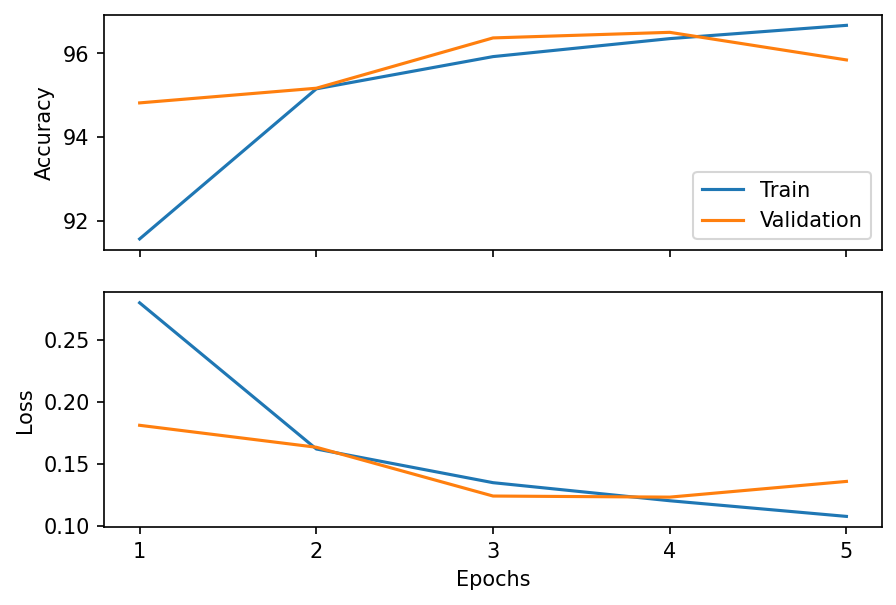

Test steps: 313 0.87s test_loss: 0.119117 test_acc: 96.310000                                                  
Précision en test: 96.31


In [42]:
optimizer = optim.Adam(net.fc.parameters(), lr=lr) # On optimise uniquement la couche pleinement connectée.
history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

Entraînons maintenant le même réseau mais cette fois-ci, laissez l'optimiseur Adam faire son travail d'optimiser les couches à convolutions. Nous pourrons en même temps comparer si nos filtres faits à la main compétitionne avec les filtres entraînés. Remarquez cependant qu'ici, nous entraînons seulement avec 6 filtres et 1 seule couche alors qu'il est possible d'entraîner un réseau avec des milliers de filtres et plusieurs dizaines de couches.

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.66s loss: 0.378878 acc: 89.447917 val_loss: 0.222709 val_acc: 93.066667
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.67s loss: 0.178447 acc: 94.879167 val_loss: 0.153471 val_acc: 95.616667
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.66s loss: 0.127809 acc: 96.358333 val_loss: 0.119501 val_acc: 96.491667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.77s loss: 0.103279 acc: 97.052083 val_loss: 0.100397 val_acc: 97.000000
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.70s loss: 0.088966 acc: 97.358333 val_loss: 0.098943 val_acc: 96.991667


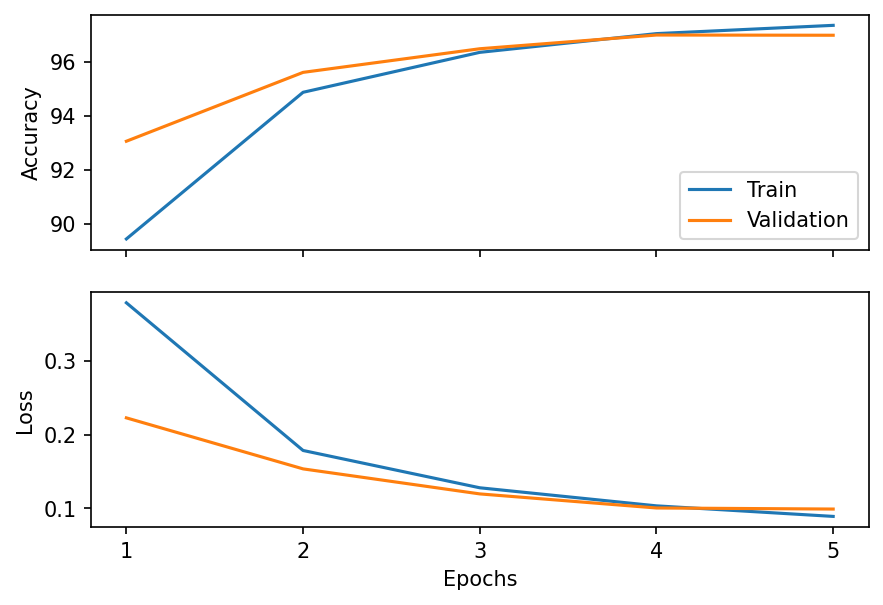

Test steps: 313 0.89s test_loss: 0.095445 test_acc: 97.080000                                                  
Précision en test: 97.08


In [60]:
net = Net()
net.cuda()

# On optimise autant la couche à convolution que la couche de classification.
optimizer = optim.Adam(net.parameters(), lr=lr)

history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

Visualisons les filtres qui ont été appris par le réseau.

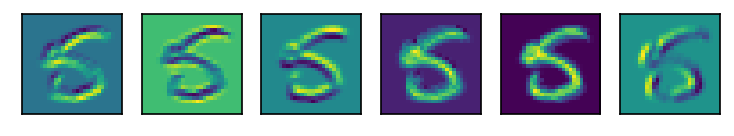

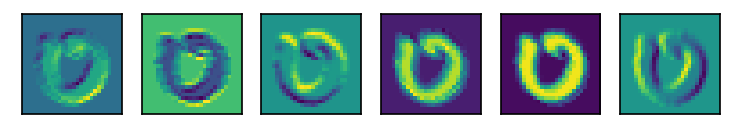

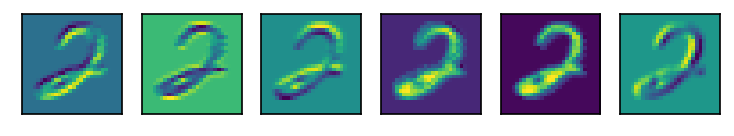

In [61]:
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

## Utilisation des filtres à convolutions

Comme on peut le constater dans l'interface de la classe [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) de PyTorch, les couches à convolutions ont des hyperparamètres ayant tous divers effets. Dans cette section, nous explorerons les plus importants.

Voici donc l'interface simplifiée de la classe:

`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`

Lorsqu'on utilise la classe, elle s'attend à recevoir en entrée un tenseur de taille `(taille de la batch, canaux, hauteur, largeur)`. Par exemple dans le cas de CIFAR10, on aurait en tenseur de taille `(taille de la batch, 3, 32, 32)`. Créons-nous un tenseur de taille similaire avec une taille de batch de 8 afin de tester la classe `nn.Conv2d` de PyTorch.

In [11]:
image_batch = torch.randn(8, 3, 32, 32)

Notez que le premier paramètre `in_channels` de `nn.Conv2d` doit correspondre au nombre de canaux (*channels*) du tenseur donné en entrée de la couche. Par exemple, la couche à convolution de 100 filtres 3x3 que l'on crée dans **le code suivant va nous donner une erreur** étant donné qu'on spécifie 2 canaux au lieu de 3.

In [12]:
conv = nn.Conv2d(2, 100, 3)
conv(image_batch)

RuntimeError: Given groups=1, weight of size [100, 2, 3, 3], expected input[8, 3, 32, 32] to have 2 channels, but got 3 channels instead

Créons maintenant une couche à convolution de 100 filtres 3x3 avec le bon nombre de canaux en entrée et regardons la shape du tenseur résultant.

In [48]:
conv = nn.Conv2d(3, 100, 3)
conv(image_batch).shape

torch.Size([8, 100, 30, 30])

On remarque que la taille du tenseur de sortie a 100 canaux étant donné qu'on a demandé 100 filtres à convolution. On remarque aussi que la hauteur et la largeur ont diminué de 2 dû à la convolution. Pour pallier à ceci, ajoutons un padding de 1.

In [49]:
conv = nn.Conv2d(3, 100, 3, padding=1)
conv(image_batch).shape

torch.Size([8, 100, 32, 32])

#### Exercice

- Quand vient le temps d'empiler les couches à convolution, il faut tenir compte du nombre de canaux en sortie de la couche précédente pour la couche suivante. Corrigez le code ci-dessous pour que l'appel des couches à convolution s'effectue sans erreur.

In [50]:
"""
# TODO Corrigez le code suivant
conv1 = nn.Conv2d(3, 100, 3, padding=1)
conv2 = nn.Conv2d(3, 100, 3, padding=1)
conv2(conv1(image_batch)).shape
"""

conv1 = nn.Conv2d(3, 100, 3, padding=1)
conv2 = nn.Conv2d(100, 100, 3, padding=1)
conv2(conv1(image_batch)).shape

torch.Size([8, 100, 32, 32])

#### Exercice

- Testons maintenant avec des filtres de tailles différentes. On remarquera que la hauteur et la largeur ont changé avec des filtres plus gros. Ajustez le padding pour que la hauteur et la largeur restent les mêmes, c'est-à-dire 32x32.

In [51]:
"""
conv = nn.Conv2d(3, 100, 5, padding=1)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=1)
print("Filtre 7x7:", conv(image_batch).shape)
"""

conv = nn.Conv2d(3, 100, 5, padding=2)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=3)
print("Filtre 7x7:", conv(image_batch).shape)

Filtre 5x5: torch.Size([8, 100, 32, 32])
Filtre 7x7: torch.Size([8, 100, 32, 32])


Mettons maintenant un *stride* de 2. Ceci va faire en sorte que les filtres à convolutions auront des déplacements de taille 2 au lieu de 1.

In [52]:
conv = nn.Conv2d(3, 100, 3, padding=1, stride=2)
conv(image_batch).shape

torch.Size([8, 100, 16, 16])

On remarque que la hauteur et la largeur du tenseur résultant ont été divisées par 2.

## Architecture de base

#### Exercice

- Implémentez une architecture de base de réseau de neurones à convolution pour CIFAR10 ayant les caractéristiques suivantes.

    1. 3 couches à convolution (voir [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)).
    2. Toutes les couches ont 100 filtres de taille 3x3 et 1 de padding.
    3. Batch normalization après chaque couche (voir [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)).
    4. Utiliser la ReLU comme fonction d'activation (Voir [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).
    5. Maxpooling avec un noyau de taille 2 après les 2 premières couches. (Voir [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)).
    6. 1 seule couche linéaire pour la classification (aucune activation nécessaire) (Voir [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)).

Ne pas oublier d'utiliser [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) avant la couche de classification sinon vous allez obtenir des erreurs de *shape*.

Essentiellement, chaque couche devrait consister en `Conv2d -> BatchNorm2d -> ReLU` suivi de `MaxPool2d` pour les deux premières couches. Notez que le maxpooling et la ReLU pourraient être échangés étant donné que tous les deux sont des opérations de maximum. Pour vous faciliter les prochains exercices, on vous demande de suivre l'ordre donné ici.

Notez que la taille des images de CIFAR10 est de 3x32x32 (images en couleur). Il faut donc tenir en compte de cela lors de l'instanciation de la première couche à convolutions.

In [66]:
"""
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):       
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [67]:
lr = 0.001
n_epoch = 5
batch_size = 32

Epoch: 1/5 Train steps: 1250 Val steps: 313 8.75s loss: 1.246872 acc: 56.787500 val_loss: 1.235160 val_acc: 59.190000
Epoch: 2/5 Train steps: 1250 Val steps: 313 8.69s loss: 0.835957 acc: 70.982500 val_loss: 1.390018 val_acc: 57.930000
Epoch: 3/5 Train steps: 1250 Val steps: 313 8.68s loss: 0.680843 acc: 76.357500 val_loss: 1.113960 val_acc: 65.320000
Epoch: 4/5 Train steps: 1250 Val steps: 313 8.77s loss: 0.577242 acc: 79.930000 val_loss: 0.878966 val_acc: 71.630000
Epoch: 5/5 Train steps: 1250 Val steps: 313 8.60s loss: 0.478346 acc: 83.272500 val_loss: 0.837028 val_acc: 73.680000


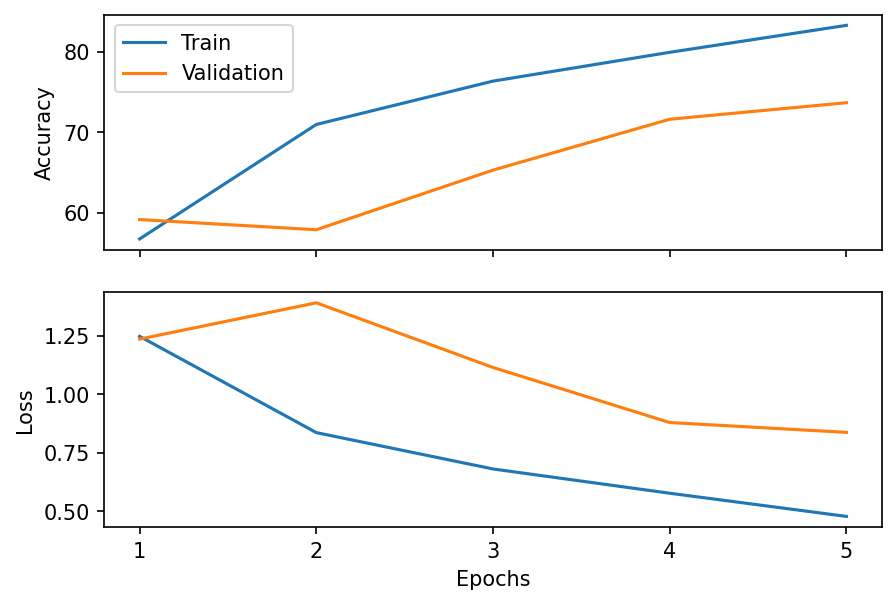

Test steps: 313 1.15s test_loss: 0.836596 test_acc: 73.200000                                                 
Précision en test: 73.20


In [68]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Architecture profonde

#### Exercice

- Ajoutez 2 couches de convolution de 100 filtres dans le réseau précédent (n'oubliez pas la batch normalization et le padding). Mettez du maxpooling après la couche 1 et 3. Comparez les résultats.

In [24]:
"""
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)
        
        self.conv4 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(100)
        
        self.conv5 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(100)
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.flatten(1)
        x = self.fc(x)
        return x

Epoch: 1/5 Train steps: 1250 Val steps: 313 10.17s loss: 1.269097 acc: 55.452500 val_loss: 1.190755 val_acc: 59.600000
Epoch: 2/5 Train steps: 1250 Val steps: 313 10.34s loss: 0.811726 acc: 71.775000 val_loss: 0.993567 val_acc: 65.560000
Epoch: 3/5 Train steps: 1250 Val steps: 313 10.34s loss: 0.635618 acc: 77.940000 val_loss: 0.725272 val_acc: 75.220000
Epoch: 4/5 Train steps: 1250 Val steps: 313 10.23s loss: 0.516211 acc: 82.115000 val_loss: 0.704917 val_acc: 75.880000
Epoch: 5/5 Train steps: 1250 Val steps: 313 10.28s loss: 0.413302 acc: 85.470000 val_loss: 0.654332 val_acc: 77.960000


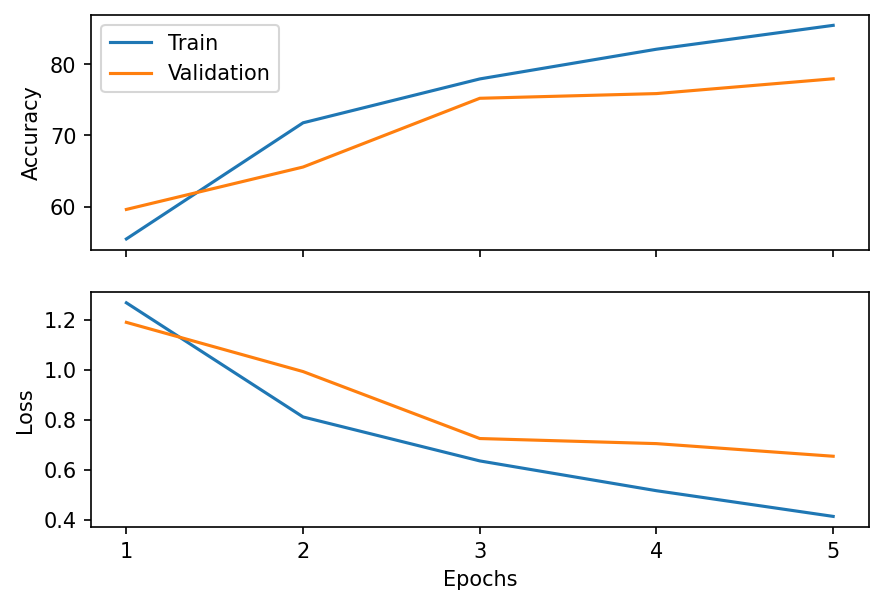

Test steps: 313 1.24s test_loss: 0.676443 test_acc: 77.830000                                                 
Précision en test: 77.83


In [25]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question
- Que remarquez-vous par rapport au performance du réseau précédent? 
    
    **En rajoutant quelques couches, dans ce cas-ci, les performances sont augmentés.**

#### Exercice

- Codez le réseau ci-dessous qui prend en paramètre le nombre de couches désiré. Vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) pour pouvoir avoir un nombre variable de couches. Encore une fois, chaque couche va consister en 100 filtres à convolution 3x3 avec padding de 1 suivi d'une batch normalization et d'une ReLU. Mettez du maxpooling après les couches 3 et 5. Vous pouvez supposer que le nombres de couche demandé est plus de 5. Entrainez ensuite le réseau avec 51 couches.

    L'entraînement risque de prendre un certain temps. Vous avez certainement le temps d'aller prendre un bon café.

In [26]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(nn.Conv2d(100, 100, 3, padding=1))
            self.bns.append(nn.BatchNorm2d(100))
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Cette boucle parcourt les couches 2 à num_layers.
        for layer_number, conv, bn in zip(range(2, self.num_layers + 1), self.convs, self.bns):
            x = F.relu(bn(conv(x)))
            if layer_number in [3, 5]:
                x = F.max_pool2d(x, 2)
        
        x = x.flatten(1)
        x = self.fc(x)
        return x

Epoch: 1/5 Train steps: 1250 Val steps: 313 46.65s loss: 2.292613 acc: 11.802500 val_loss: 2.218610 val_acc: 13.490000
Epoch: 2/5 Train steps: 1250 Val steps: 313 46.36s loss: 2.053340 acc: 18.432500 val_loss: 1.993718 val_acc: 20.410000
Epoch: 3/5 Train steps: 1250 Val steps: 313 46.58s loss: 2.146807 acc: 16.825000 val_loss: 2.294866 val_acc: 10.200000
Epoch: 4/5 Train steps: 1250 Val steps: 313 46.63s loss: 2.004345 acc: 19.645000 val_loss: 1.941897 val_acc: 21.290000
Epoch: 5/5 Train steps: 1250 Val steps: 313 46.62s loss: 1.877260 acc: 24.335000 val_loss: 1.823482 val_acc: 27.030000


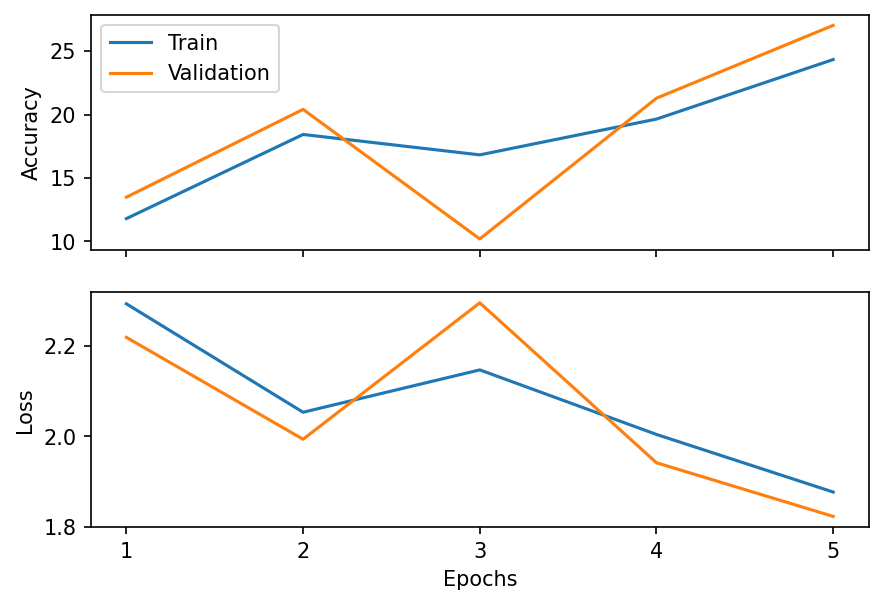

Test steps: 313 2.69s test_loss: 1.822740 test_acc: 26.190000                                                 
Précision en test: 26.19


In [27]:
model = ConvNet(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question

- Que remarquez-vous par rapport au performance du réseau précédent? 
    
    **En rajoutant beaucoup de couches, dans ce cas-ci, les performances sont diminués.**

### Un petit défi (exercice facultatif)

PyTorch fournit l'interface de programmation [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) permettant de programmer et de visualiser plus facilement les réseaux programmables sous forme de couches. Au lieu d'hériter de la classe [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), on instancie un objet `nn.Sequential` avec les couches désirés en paramètre. L'objet `nn.Sequential` se chargera d'appeler dans l'ordre fourni chaque couche avec en entrée la sortie de la couche précédente.

Prenons l'exemple ci-dessous qui contient seulement une couche à convolutions, quelques activations et une couche linéaire.

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.fc = nn.Linear(100 * 16 * 16, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=25600, out_features=10, bias=True)
)


En utilisant l'interface `nn.Sequential`, On peut simplifier le code comme ci-dessous. On remarquera également qu'avec l'affichage d'un réseau utilisant `nn.Sequential`, les opérations exécutées par le réseau sont beaucoup clairs et explicites qu'avec `nn.Module`.

In [29]:
def create_sequential_network():
    return nn.Sequential(
        nn.Conv2d(3, 100, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(100 * 16 * 16, 10)
    )

net = create_sequential_network()
print(net)

Sequential(
  (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=25600, out_features=10, bias=True)
)


On vous soumet donc ici un défi. Le but est de réimplémenter le réseau que l'on vient de coder en utilisant l'interface `nn.Sequential`.

In [69]:
"""
def create_sequential_conv_net(num_layers):
    assert num_layers > 5
    layers = []

    # TODO Ajoutez les couches à la liste "layers" ici.

    return nn.Sequential(*layers)
"""

def create_sequential_conv_net(num_layers):
    assert num_layers > 5

    # Création de la première couche.
    layers = [
        nn.Conv2d(3, 100, 3, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU()
    ]

    # Cette boucle ajoute les couches 2 à num_layers.
    for layer_number in range(2, num_layers + 1):
        layers.append(nn.Conv2d(100, 100, 3, padding=1))
        layers.append(nn.BatchNorm2d(100))
        layers.append(nn.ReLU())
        if layer_number in [3, 5]: 
            layers.append(nn.MaxPool2d(2))

    layers.append(nn.Flatten())
    layers.append(nn.Linear(100 * 8 * 8, 10))

    return nn.Sequential(*layers)

In [73]:
model = create_sequential_conv_net(51)
# print(model)

Il n'est pas nécessaire d'effectuer l'entraînement au complet, juste de confirmer que votre implémentation a des performances similaires à votre implémentation précédente.

Epoch: 1/5 Step: 1250/1250 100.00% |████████████████████|67.92s loss: 2.288781 acc: 11.132500 val_loss: 2.146184 val_acc: 16.130000
Epoch: 2/5 Step: 1250/1250 100.00% |████████████████████|68.04s loss: 1.939824 acc: 21.100000 val_loss: 1.851246 val_acc: 26.110000
Epoch: 3/5 Step: 1250/1250 100.00% |████████████████████|67.30s loss: 1.776968 acc: 30.755000 val_loss: 1.651018 val_acc: 34.720000
Epoch: 4/5 Step: 1250/1250 100.00% |████████████████████|67.02s loss: 1.560040 acc: 40.750000 val_loss: 1.778154 val_acc: 37.000000
Epoch: 5/5 Step: 1250/1250 100.00% |████████████████████|67.52s loss: 1.687214 acc: 35.270000 val_loss: 1.756000 val_acc: 33.280000


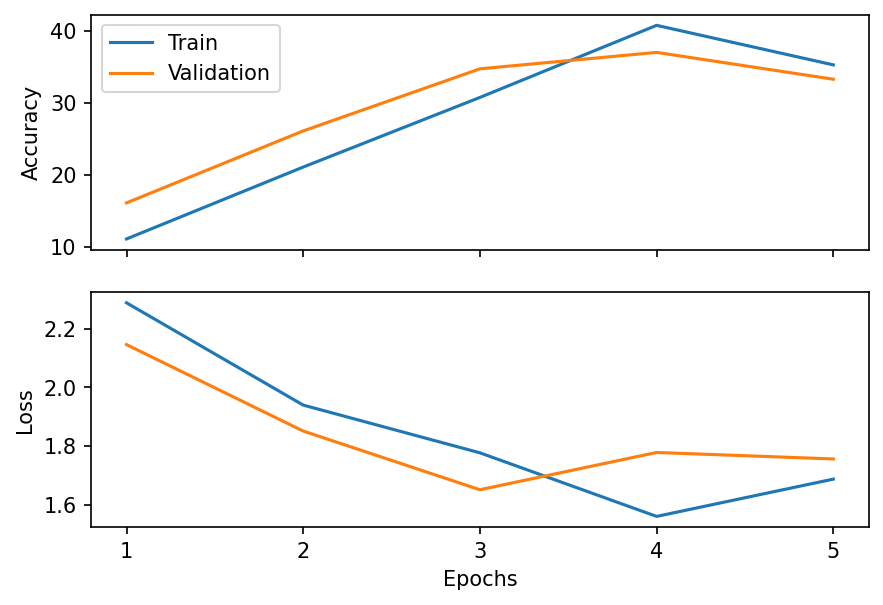

Précision en test: 33.14


In [28]:
model = create_sequential_conv_net(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Connexion résiduelle

Comme vous avez pu le constater, ajouter de plus en plus de couches augmente aussi la difficulté avec laquelle le gradient peut se propager dans le réseau. Une des solutions suggérées est d'utiliser une connexion résiduelle permettant au gradient de _sauter_ des couches. Dans l'article présentant cette connexion, elle est définie comme suit:

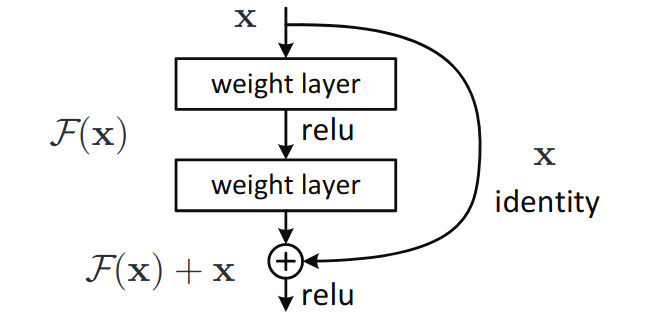

#### Exercice

- Implémentez cette connexion sous une forme de couche dans la classe `ResidualLayer` ci-dessous. Vous pouvez la tester avec le réseau `ShallowResnet` fourni ci-bas. Dans notre cas, chaque *weight layer* consiste en une couche à convolution à 100 filtres 3x3 avec padding de 1 suivi d'une batch normalization. Prenez pour acquis que le nombre de *canaux* en entrée de votre couche sera de 100.

In [31]:
"""
class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self, x):
        pass
"""

class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)

        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
    
    def forward(self, x):
        res = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = F.relu(x + res)
        return x

Testez votre implémentation de votre couche résiduelle avec le réseau peu profond ci-dessous.

In [32]:
class ShallowResnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.res1 = ResidualLayer()
        self.res2 = ResidualLayer()
        self.res3 = ResidualLayer()

        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = F.max_pool2d(x, 2)
        x = self.res2(x)
        x = F.max_pool2d(x, 2)
        x = self.res3(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

Il n'est pas nécessaire d'effectuer l'entraînement au complet, juste de confirmer que votre implémentation a des "bonnes" performances.

Epoch: 1/5 Step: 1250/1250 100.00% |████████████████████|18.73s loss: 1.631797 acc: 49.277500 val_loss: 1.221632 val_acc: 60.960000
Epoch: 2/5 Step: 1250/1250 100.00% |████████████████████|18.54s loss: 0.969174 acc: 66.855000 val_loss: 0.927580 val_acc: 68.010000
Epoch: 3/5 Step: 1250/1250 100.00% |████████████████████|18.46s loss: 0.778676 acc: 72.917500 val_loss: 0.804430 val_acc: 73.000000
Epoch: 4/5 Step: 1250/1250 100.00% |████████████████████|18.54s loss: 0.648016 acc: 77.675000 val_loss: 0.783351 val_acc: 73.300000
Epoch: 5/5 Step: 1250/1250 100.00% |████████████████████|18.85s loss: 0.533619 acc: 81.532500 val_loss: 0.710497 val_acc: 76.210000


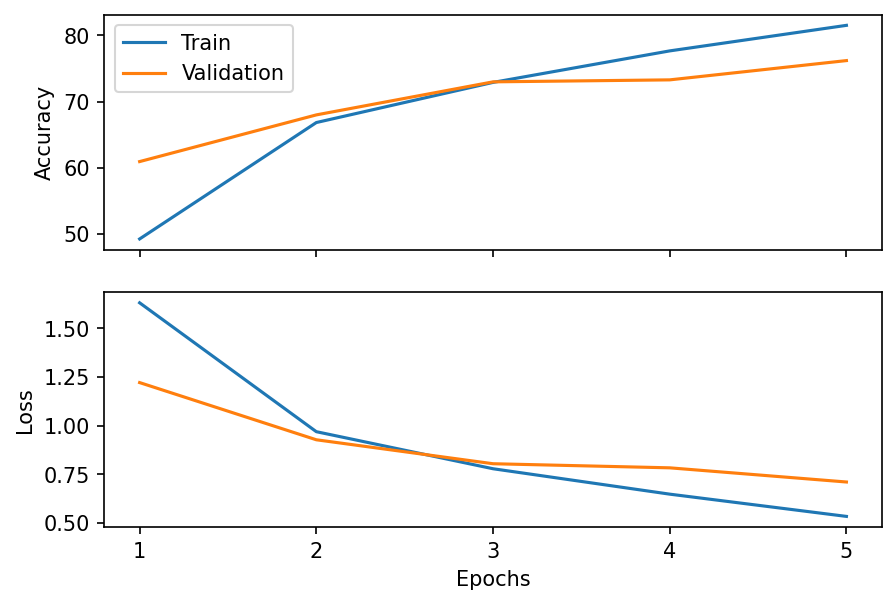

Précision en test: 76.61


In [31]:
model = ShallowResnet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Exercice

- Codez le réseau à connexion résiduelle ci-dessous qui prend en paramètre le nombre de couches résiduelles désiré. Encore une fois, vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) ou [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) pour pouvoir avoir un nombre variable de couches. Notez qu'ici `num_layers` représente le nombre de couches résiduelles et non le nombre de couches à convolution. Le réseau devrait consister d'une couche `Conv2d -> BatchNorm2d -> ReLU` suivi de `num_layers` couches résiduelles et terminer par la couche de classification. Faites un maxpool après les couches résiduelles 1 et 2. 

    Entrainez le réseau avec 25 couches résiduelles (donc au total 51 couches à convolution si compte la première couche non résiduelle).

In [33]:
"""
class Resnet(nn.Module):
    def __init__(self, num_layers):
        super(Resnet, self).__init__()
        pass

    def forward(self, x):
        pass
"""


class Resnet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 2
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.layers = nn.ModuleList([
            ResidualLayer() for _ in range(num_layers)
        ])
            
        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i <= 1:
                x = F.max_pool2d(x, 2)

        x = x.flatten(1)
        x = self.fc1(x)
        return x

Epoch: 1/5 Train steps: 1250 Val steps: 313 47.40s loss: 2.003018 acc: 47.890000 val_loss: 1.174795 val_acc: 63.770000
Epoch: 2/5 Train steps: 1250 Val steps: 313 47.49s loss: 0.962364 acc: 67.667500 val_loss: 1.251770 val_acc: 67.440000
Epoch: 3/5 Train steps: 1250 Val steps: 313 47.41s loss: 0.753434 acc: 74.690000 val_loss: 0.789194 val_acc: 73.340000
Epoch: 4/5 Train steps: 1250 Val steps: 313 47.53s loss: 0.615535 acc: 79.052500 val_loss: 0.720613 val_acc: 75.730000
Epoch: 5/5 Train steps: 1250 Val steps: 313 47.43s loss: 0.481095 acc: 83.412500 val_loss: 0.707376 val_acc: 76.830000


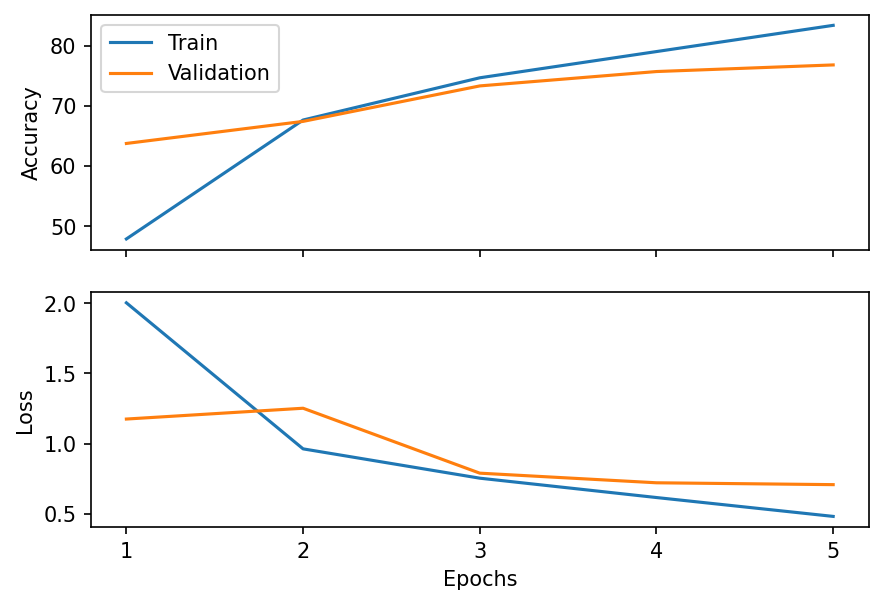

Test steps: 313 2.92s test_loss: 0.715000 test_acc: 76.510000                                                 
Précision en test: 76.51


In [34]:
model = Resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question

- Comparez les résultats et la vitesse avec laquelle le réseau a entraîné par rapport au réseau à convolution de 51 couches entrainé plus haut. 

    **On remarque que les connexions résiduelles ont aidé l'entraînement.**

#### Exercice facultatif

- Comme le défi lancé précédemment, tentez d'implémenter le réseau à connexion résiduelle en n'utilisant que l'interface `nn.Sequential`. Vous pouvez utiliser la couche `ResidualLayer` définie précédemment.

In [74]:
"""
def create_sequential_resnet(num_layers):
    assert num_layers > 2
    layers = []
    
    # TODO Ajoutez les couches à la liste "layers" ici.

    return nn.Sequential(*layers)
"""

def create_sequential_resnet(num_layers):
    assert num_layers > 2

    layers = [
        nn.Conv2d(3, 100, 3, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU()
    ]

    for i in range(num_layers):
        layers.append(ResidualLayer())
        if i <= 1:
            layers.append(nn.MaxPool2d(2))

    layers.append(nn.Flatten())
    layers.append(nn.Linear(100 * 8 * 8, 10))

    return nn.Sequential(*layers)

In [79]:
model = create_sequential_resnet(3)
print(model)

Sequential(
  (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ResidualLayer(
    (conv1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ResidualLayer(
    (conv1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Il n'est pas nécessaire d'effectuer l'entraînement au complet, juste de confirmer que votre implémentation a des performances similaires à votre implémentation précédente.

Epoch: 1/5 Step: 1250/1250 100.00% |████████████████████|67.87s loss: 1.988628 acc: 48.770000 val_loss: 1.265438 val_acc: 61.470000
Epoch: 2/5 Step: 1250/1250 100.00% |████████████████████|67.73s loss: 0.906777 acc: 68.932500 val_loss: 0.849030 val_acc: 70.910000
Epoch: 3/5 Step: 1250/1250 100.00% |████████████████████|67.67s loss: 0.688237 acc: 76.195000 val_loss: 0.748571 val_acc: 74.400000
Epoch: 4/5 Step: 1250/1250 100.00% |████████████████████|67.58s loss: 0.560686 acc: 80.705000 val_loss: 0.719947 val_acc: 76.090000
Epoch: 5/5 Step: 1250/1250 100.00% |████████████████████|67.54s loss: 0.450045 acc: 84.360000 val_loss: 0.699689 val_acc: 77.170000


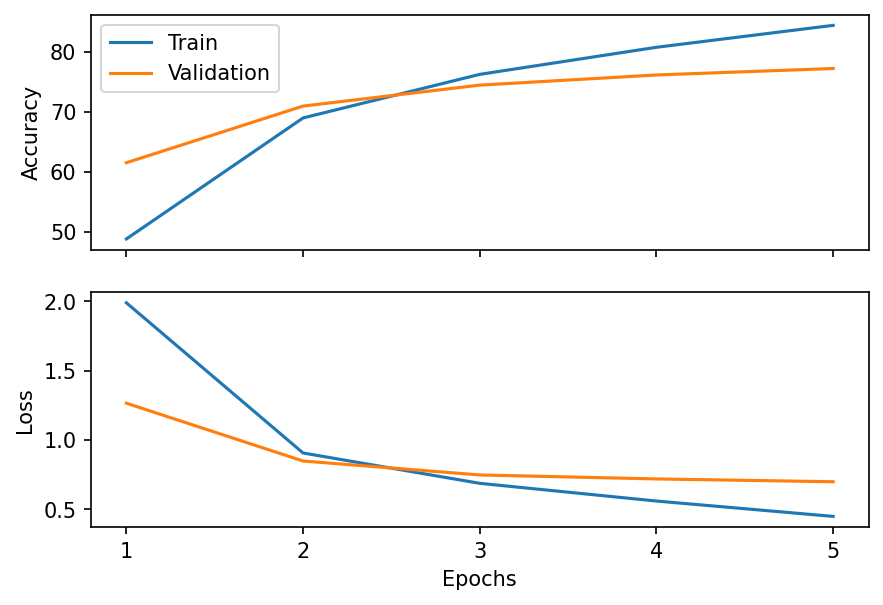

Précision en test: 77.69


In [35]:
model = create_sequential_resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))